# Анализ продаж
### Требуется:
- Произвести исследование
- Предсказать продажи в будущем квартале

## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy.stats import linregress

## Загрузка БД

In [2]:
dataset = pd.read_excel("dataset.xlsx")
dataset.head()

,order_id,product_id,price,count,profit_per_item,status,is_rental,date_confirm
0,0,0,24.34,1,14.44,Returned,1,2023-08-02
1,0,4,23.98,1,-1.16,Returned,1,2023-08-02
2,0,5,13.30,1,3.40,Shipped,0,2023-08-02
3,2932,3526,33.23,1,6.60,Shipped,0,2023-08-03
4,4154,5117,115.37,1,27.89,Shipped,0,2023-08-01


In [3]:
dataset.shape

(116342, 8)

## Подготовка данных

Проверка базы данных на NaN значения

In [4]:
dataset.isnull().sum()

order_id           0
product_id         0
price              0
count              0
profit_per_item    0
status             0
is_rental          0
date_confirm       0
dtype: int64

Отсортируем базу данных по order_id и product_id и удалим дубликаты полей

In [5]:
dataset.sort_values(["order_id","product_id"], inplace = True)
dataset.reset_index(drop=True, inplace=True)
dataset.head()

,order_id,product_id,price,count,profit_per_item,status,is_rental,date_confirm
0,0,0,24.34,1,14.44,Returned,1,2023-08-02
1,0,4,23.98,1,-1.16,Returned,1,2023-08-02
2,0,5,13.30,1,3.40,Shipped,0,2023-08-02
3,2932,3526,33.23,1,6.60,Shipped,0,2023-08-03
4,3824,14261,21.00,1,-2.52,Shipped,1,2023-08-02


In [6]:
dataset.drop_duplicates(inplace=True)

In [7]:
dataset.describe()

,order_id,product_id,price,count,profit_per_item,is_rental,date_confirm
count,1.163420e+05,1.163420e+05,116342.000000,116342.000000,116342.000000,116342.000000,116342
mean,8.115423e+05,9.987892e+05,39.756804,1.023766,16.067544,0.418146,2024-01-31 21:55:32.774062336
min,0.000000e+00,0.000000e+00,8.550000,1.000000,-280.350000,0.000000,2023-08-01 00:00:00
25%,4.269740e+05,5.077522e+05,22.810000,1.000000,4.300000,0.000000,2023-10-27 00:00:00
50%,8.020095e+05,9.696545e+05,32.940000,1.000000,9.190000,0.000000,2024-01-23 00:00:00
75%,1.231006e+06,1.518396e+06,47.270000,1.000000,21.760000,1.000000,2024-05-15 00:00:00
max,1.577977e+06,2.019285e+06,477.350000,30.000000,799.160000,1.000000,2024-07-31 00:00:00
std,4.588995e+05,5.801687e+05,26.855720,0.313542,28.738305,0.493257,NaN


Для удобства последующих группировок разобьем заказы по неделям, а также рассчитаем общую цену и прибыль для каждого заказа

In [8]:
min_date = dataset["date_confirm"].min()
dataset["week"] = [int((d-min_date).days/7) for d in pd.to_datetime(dataset["date_confirm"])]
dataset["total_price"]=dataset["price"]*dataset["count"]
dataset["total_profit"]=dataset["profit_per_item"]*dataset["count"]
dataset=dataset[["order_id","product_id","total_price","total_profit","price"
                 ,"profit_per_item","count","status","is_rental","date_confirm","week"]]
dataset.rename(columns = {"price":"cost", "total_price":"total_cost"}, inplace=True)
dataset

,order_id,product_id,total_cost,total_profit,cost,profit_per_item,count,status,is_rental,date_confirm,week
0,0,0,24.34,14.44,24.34,14.44,1,Returned,1,2023-08-02,0
1,0,4,23.98,-1.16,23.98,-1.16,1,Returned,1,2023-08-02,0
2,0,5,13.30,3.40,13.30,3.40,1,Shipped,0,2023-08-02,0
3,2932,3526,33.23,6.60,33.23,6.60,1,Shipped,0,2023-08-03,0
4,3824,14261,21.00,-2.52,21.00,-2.52,1,Shipped,1,2023-08-02,0
...,...,...,...,...,...,...,...,...,...,...,...
116337,1577958,2009383,105.81,43.96,105.81,43.96,1,Shipped,0,2024-07-31,52
116338,1577958,2009389,42.49,17.18,42.49,17.18,1,Shipped,0,2024-07-31,52
116339,1577958,2009390,83.53,34.64,83.53,34.64,1,Shipped,0,2024-07-31,52
116340,1577959,2009380,98.24,48.02,98.24,48.02,1,Shipped,0,2024-07-31,52


Проверим, чтобы выручка не превышала прибыль

In [9]:
print("Price < profit times:",np.sum(dataset["total_cost"]<dataset["total_profit"]))

Price < profit times: 10068


Т.к выручка превышает прибыль более чем в 10000 случаев, будем считать, что **price — стоимость, которая тербуется чтобы произвести единицу товара**

In [10]:
months_names = ["August","September","October","November","December","January","February",
          "March","April","May","June","July"]

## Количество заказов
- Взглянем на количество заказов и выделим основные тренды

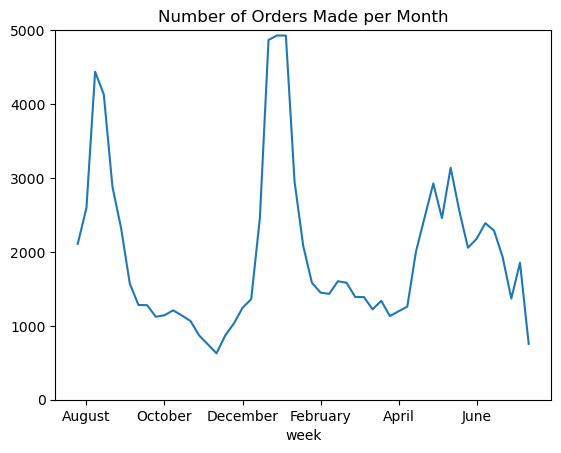

In [11]:
dataset.groupby("week")["order_id"].nunique().plot(title = "Number of Orders Made per Month")
plt.xticks(range(1,52,9),months_names[::2])
plt.ylim([0,5000])
plt.show()

- Видно, что основные пики продаж наблюдались **в начале сентября**, **в январе** и **в мае-июне**.

## Основные тенденции и стратегии продаж
- Рассмотрим, какое количество товаров возвращают, и сколько товаров сдают в аренду вместо продажи.

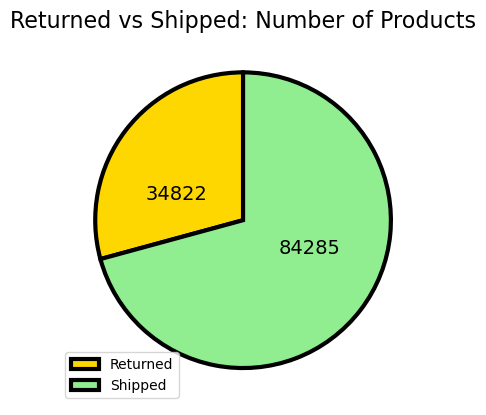

In [12]:
data = dataset.groupby("status")["count"].sum()
plt.pie(data,startangle = 90,labels = data, colors = ['gold','lightgreen'], labeldistance = 0.3,
        textprops={'fontsize': 14}, wedgeprops={"edgecolor":"k",'linewidth': 3})
plt.legend(["Returned",
       "Shipped"], loc = "lower left")
plt.title("Returned vs Shipped: Number of Products", {'fontsize': 16})
plt.show()

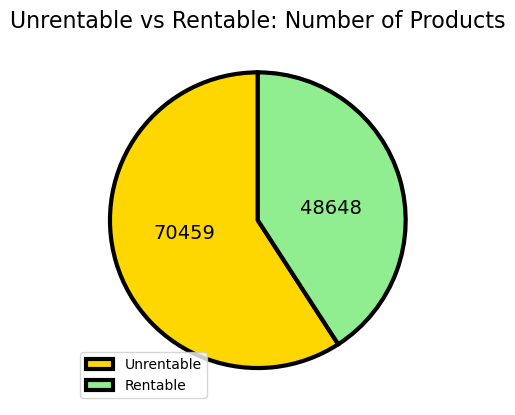

In [13]:
data = dataset.groupby("is_rental")["count"].sum()
plt.pie(data,startangle = 90,labels = data, colors = ['gold','lightgreen'], labeldistance = 0.3,
        textprops={'fontsize': 14}, wedgeprops={"edgecolor":"k",'linewidth': 3})
plt.legend(["Unrentable",
       "Rentable"], loc = "lower left")
plt.title("Unrentable vs Rentable: Number of Products", {'fontsize': 16})
plt.show()

- Видно, что вернули около **25%** всех товаров и около **40%** сдавали в аренду

## Прибыль и средние затраты

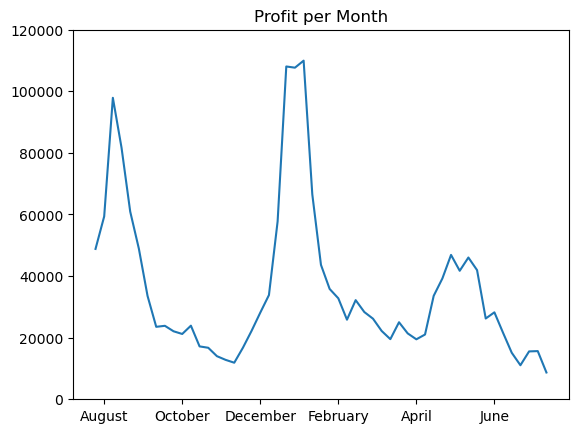

In [14]:
data = dataset.groupby("week")["total_profit"].sum()
plt.plot(data.index,data.values)
plt.ylim([0,120000])
plt.xticks(range(1,52,9),months_names[::2])
plt.title("Profit per Month")
plt.show()

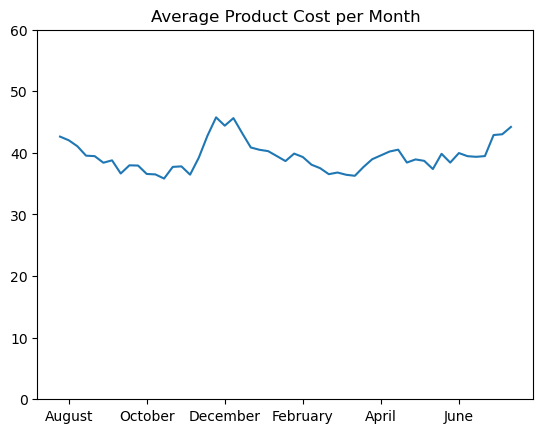

In [15]:
data = dataset.groupby("week")["cost"].mean()
plt.plot(data.index,data.values)
plt.xticks(range(1,52,9),months_names[::2])
plt.ylim([0,60])
plt.title("Average Product Cost per Month")
plt.show()

- Видно, что прибыль сильно коррелирует с количеством продаж, а средние затраты немного росли в пероиды с наибольшим спросом. 

## Цена товаров
- Рассмотрим среднюю выручку с одного товара

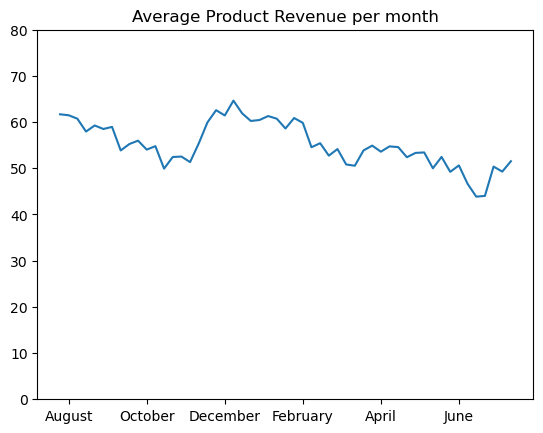

In [16]:
data = dataset.groupby("week")[["cost","profit_per_item"]].mean()
plt.plot(data.index,data["cost"]+data["profit_per_item"])
plt.xticks(range(1,52,9),months_names[::2])
plt.title("Average Product Revenue per month")
plt.ylim([0,80])
plt.show()

- Видно, что средняя выручка коррелирует с затратами

## Зависимость затрат и прибыли от возвратов

In [17]:
total_price_status = dataset.pivot_table("cost", index="week", columns = "status")
total_profit_status = dataset.pivot_table("total_profit", index="week", columns = "status")
total_price_status.tail()

status,Returned,Shipped
week,,
48,29.661073,40.275071
49,30.378851,39.846813
50,44.432857,42.876736
51,57.406875,42.923114
52,60.940000,44.130800


### Средние затраты

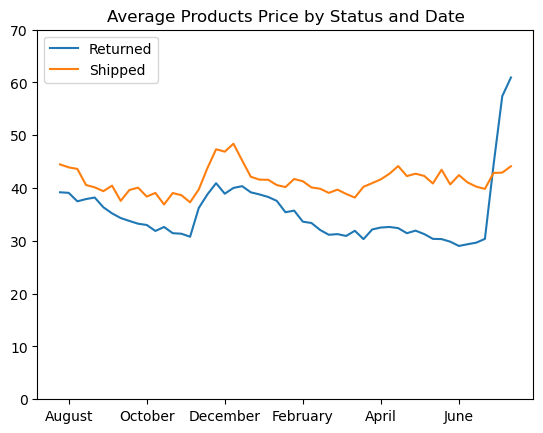

In [18]:
plt.plot(total_price_status, label = ["Returned","Shipped"])
plt.title("Average Products Price by Status and Date")
plt.ylim([0,70])
plt.xticks(range(1,52,9),months_names[::2])
plt.legend()
plt.show()

### Средняя прибыль

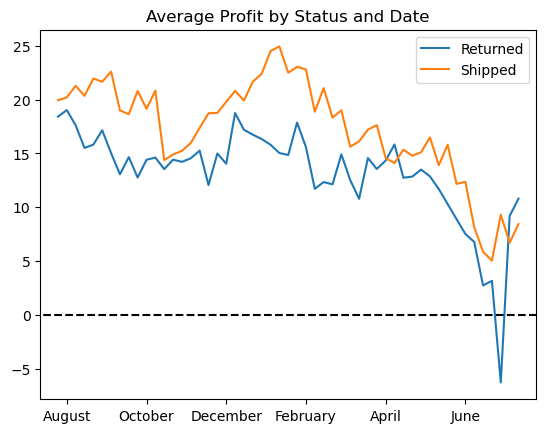

In [19]:
plt.plot(total_profit_status, label = ["Returned","Shipped"])
plt.plot(range(-10,65),np.zeros(75),ls="--",color="black")
plt.title("Average Profit by Status and Date")
plt.xticks(range(1,52,9),months_names[::2])
plt.xlim([-2,54])
plt.legend()
plt.show()

- Затраты на возвращенные продукты немного ниже, чем на продукты, которые забрали
- Также прибыль на такие товары тоже ниже
- Наблюдается резкое уменьшение прибыли вплоть до убытков **с начала мая до начало июля**

## Количество выкупленных товаров

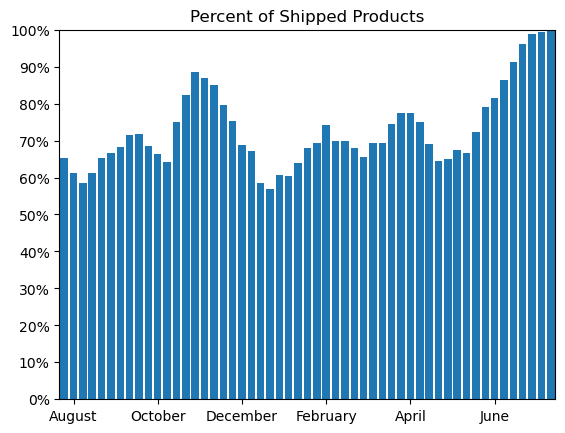

In [20]:
data = dataset.groupby("week")["status"].apply(lambda x : np.sum(x=="Shipped")/len(x)*100)
plt.bar(data.index,height=data.values)
plt.title("Percent of Shipped Products")
plt.yticks(range(0,101,10),[str(t)+'%' for t in range(0,101,10)])
plt.ylim([0,100])
plt.xlim([-0.5, 52.5])
plt.xticks(range(1,53,9),months_names[::2])
plt.show()

- Видно, что в последнее время выручка падает, при этом растет количество выкупленных товаров
- Можно предположить, что это вызвано тем, что разница между выручкой и ценой уменьшилась (например посредством скидок)

## Зависимость затрат и прибыли от сдачи в аренду

In [21]:
total_price_rental = dataset.pivot_table("cost", index="week", columns = "is_rental")
total_profit_rental = dataset.pivot_table("total_profit", index="week", columns = "is_rental")
total_price_rental.tail()

is_rental,0,1
week,,
48,45.948733,30.243013
49,43.543262,31.860013
50,45.886248,34.077106
51,45.891366,36.485239
52,47.325462,35.995230


### Средние затраты

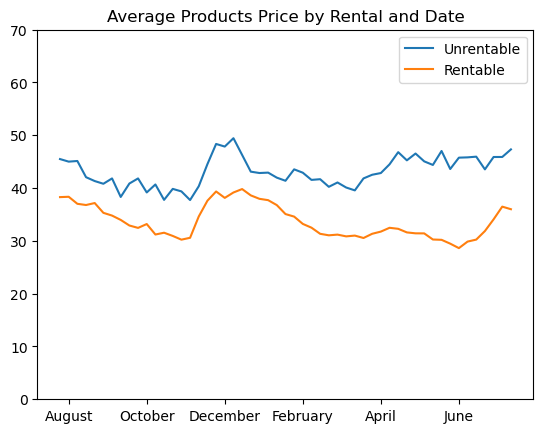

In [22]:
plt.plot(total_price_rental, label = ["Unrentable","Rentable"])
plt.title("Average Products Price by Rental and Date")
plt.ylim([0,70])
plt.xticks(range(1,52,9),months_names[::2])
plt.legend()
plt.show()

### Средняя прибыль

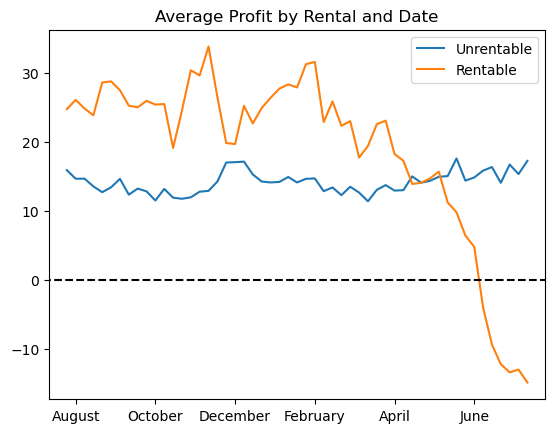

In [23]:
plt.plot(total_profit_rental, label = ["Unrentable","Rentable"])
plt.plot(range(-10,65),np.zeros(75),ls="--",color="black")
plt.title("Average Profit by Rental and Date")
plt.xticks(range(1,52,9),months_names[::2])
plt.xlim([-2,54])
plt.legend()
plt.show()

- Видно, что в последнее время сдавать продукты в аренду перестает быть выгодным, а с начала июня они являются причиной убытков
- Возможно именно аренда продуктов является причиной аномалий на прошлых графиках
- Рассмотрим количество арендованных продуктов по отношонию ко всем товарам

## Количество сдаваемых в аренду товаров 

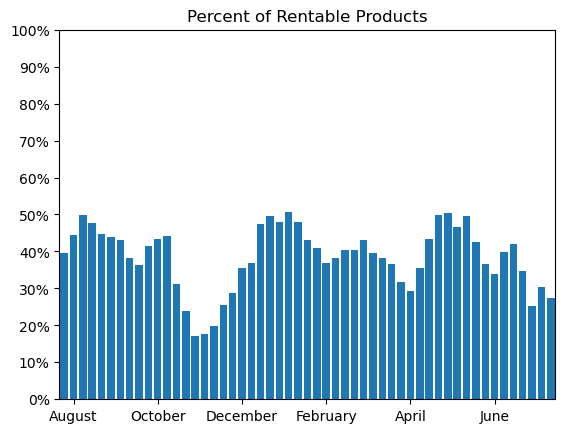

In [24]:
data = dataset.groupby("week")["is_rental"].apply(lambda x : np.sum(x==1)/len(x)*100)
plt.bar(data.index,height=data.values)
plt.title("Percent of Rentable Products")
plt.yticks(range(0,101,10),[str(t)+'%' for t in range(0,101,10)])
plt.ylim([0,100])
plt.xlim([-0.5, 52.5])
plt.xticks(range(1,53,9),months_names[::2])
plt.show()

- Около **30-40%** продуктов сдается в аренду, что, в совокупности с отрицательной прибылью таких товаров, послужило к уменьшению общей прибыли

## ROI
- Return of investments это метрика, которая помогает понять, принесли ли ваши вложения прибыль. 
- Продукт считается прибыльным, если **ROI > 0**

In [25]:
data = dataset.groupby("week")[["total_profit", "total_cost"]].sum()
ROI_per_week = data["total_profit"]/data["total_cost"]*100
ROI_per_week.head()

week
0    44.568553
1    45.915141
2    47.865890
3    46.522324
4    50.126028
dtype: float64

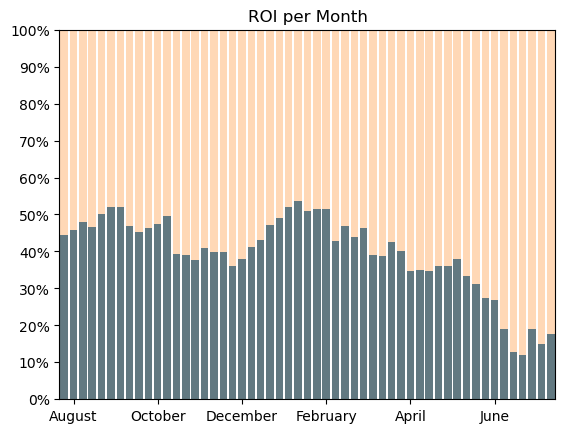

In [26]:
plt.bar(x=range(0,53),height=ROI_per_week)
plt.bar(x=range(0,53),height=100, alpha=0.3)
plt.title("ROI per Month")
plt.yticks(range(0,101,10),[str(t)+'%' for t in range(0,101,10)])
plt.ylim([0,100])
plt.xlim([-0.5, 52.5])
plt.xticks(range(1,53,9),months_names[::2])
plt.show()

- Видно, что в последнее время ROI уменьшился более чем на **20%** 

## ROI в разрезе аренды
- Теперь выясним из-за каких именно товаров уменьшился ROI

In [27]:
data = dataset.groupby(["week","is_rental"])[["total_profit","total_cost"]].sum()
ROI = (data["total_profit"]/data["total_cost"]*100).reset_index(["is_rental"]).rename(
    columns={0:"ROI"})
ROI

,is_rental,ROI
week,,
0,0,33.885716
0,1,64.601123
1,0,31.414801
1,1,68.004860
2,0,32.261977
...,...,...
50,1,-39.154192
51,0,31.661297
51,1,-35.478480


In [28]:
import matplotlib
font = {"size" : 24}
matplotlib.rc('font', **font)
def draw_bar(ax,data):
    colors = ["g" if g > 0 else "r" for g in data]
    ax.bar(x=range(0,53),height=data, color = colors)
    ax.set_xticks(range(1,53,9),months_names[::2])
    ax.set_yticks(range(-50,251,20),[str(t)+'%' for t in range(-50,251,20)])
    ax.set_ylim([-50,250])
    ax.set_xlim([-0.5,52.5])

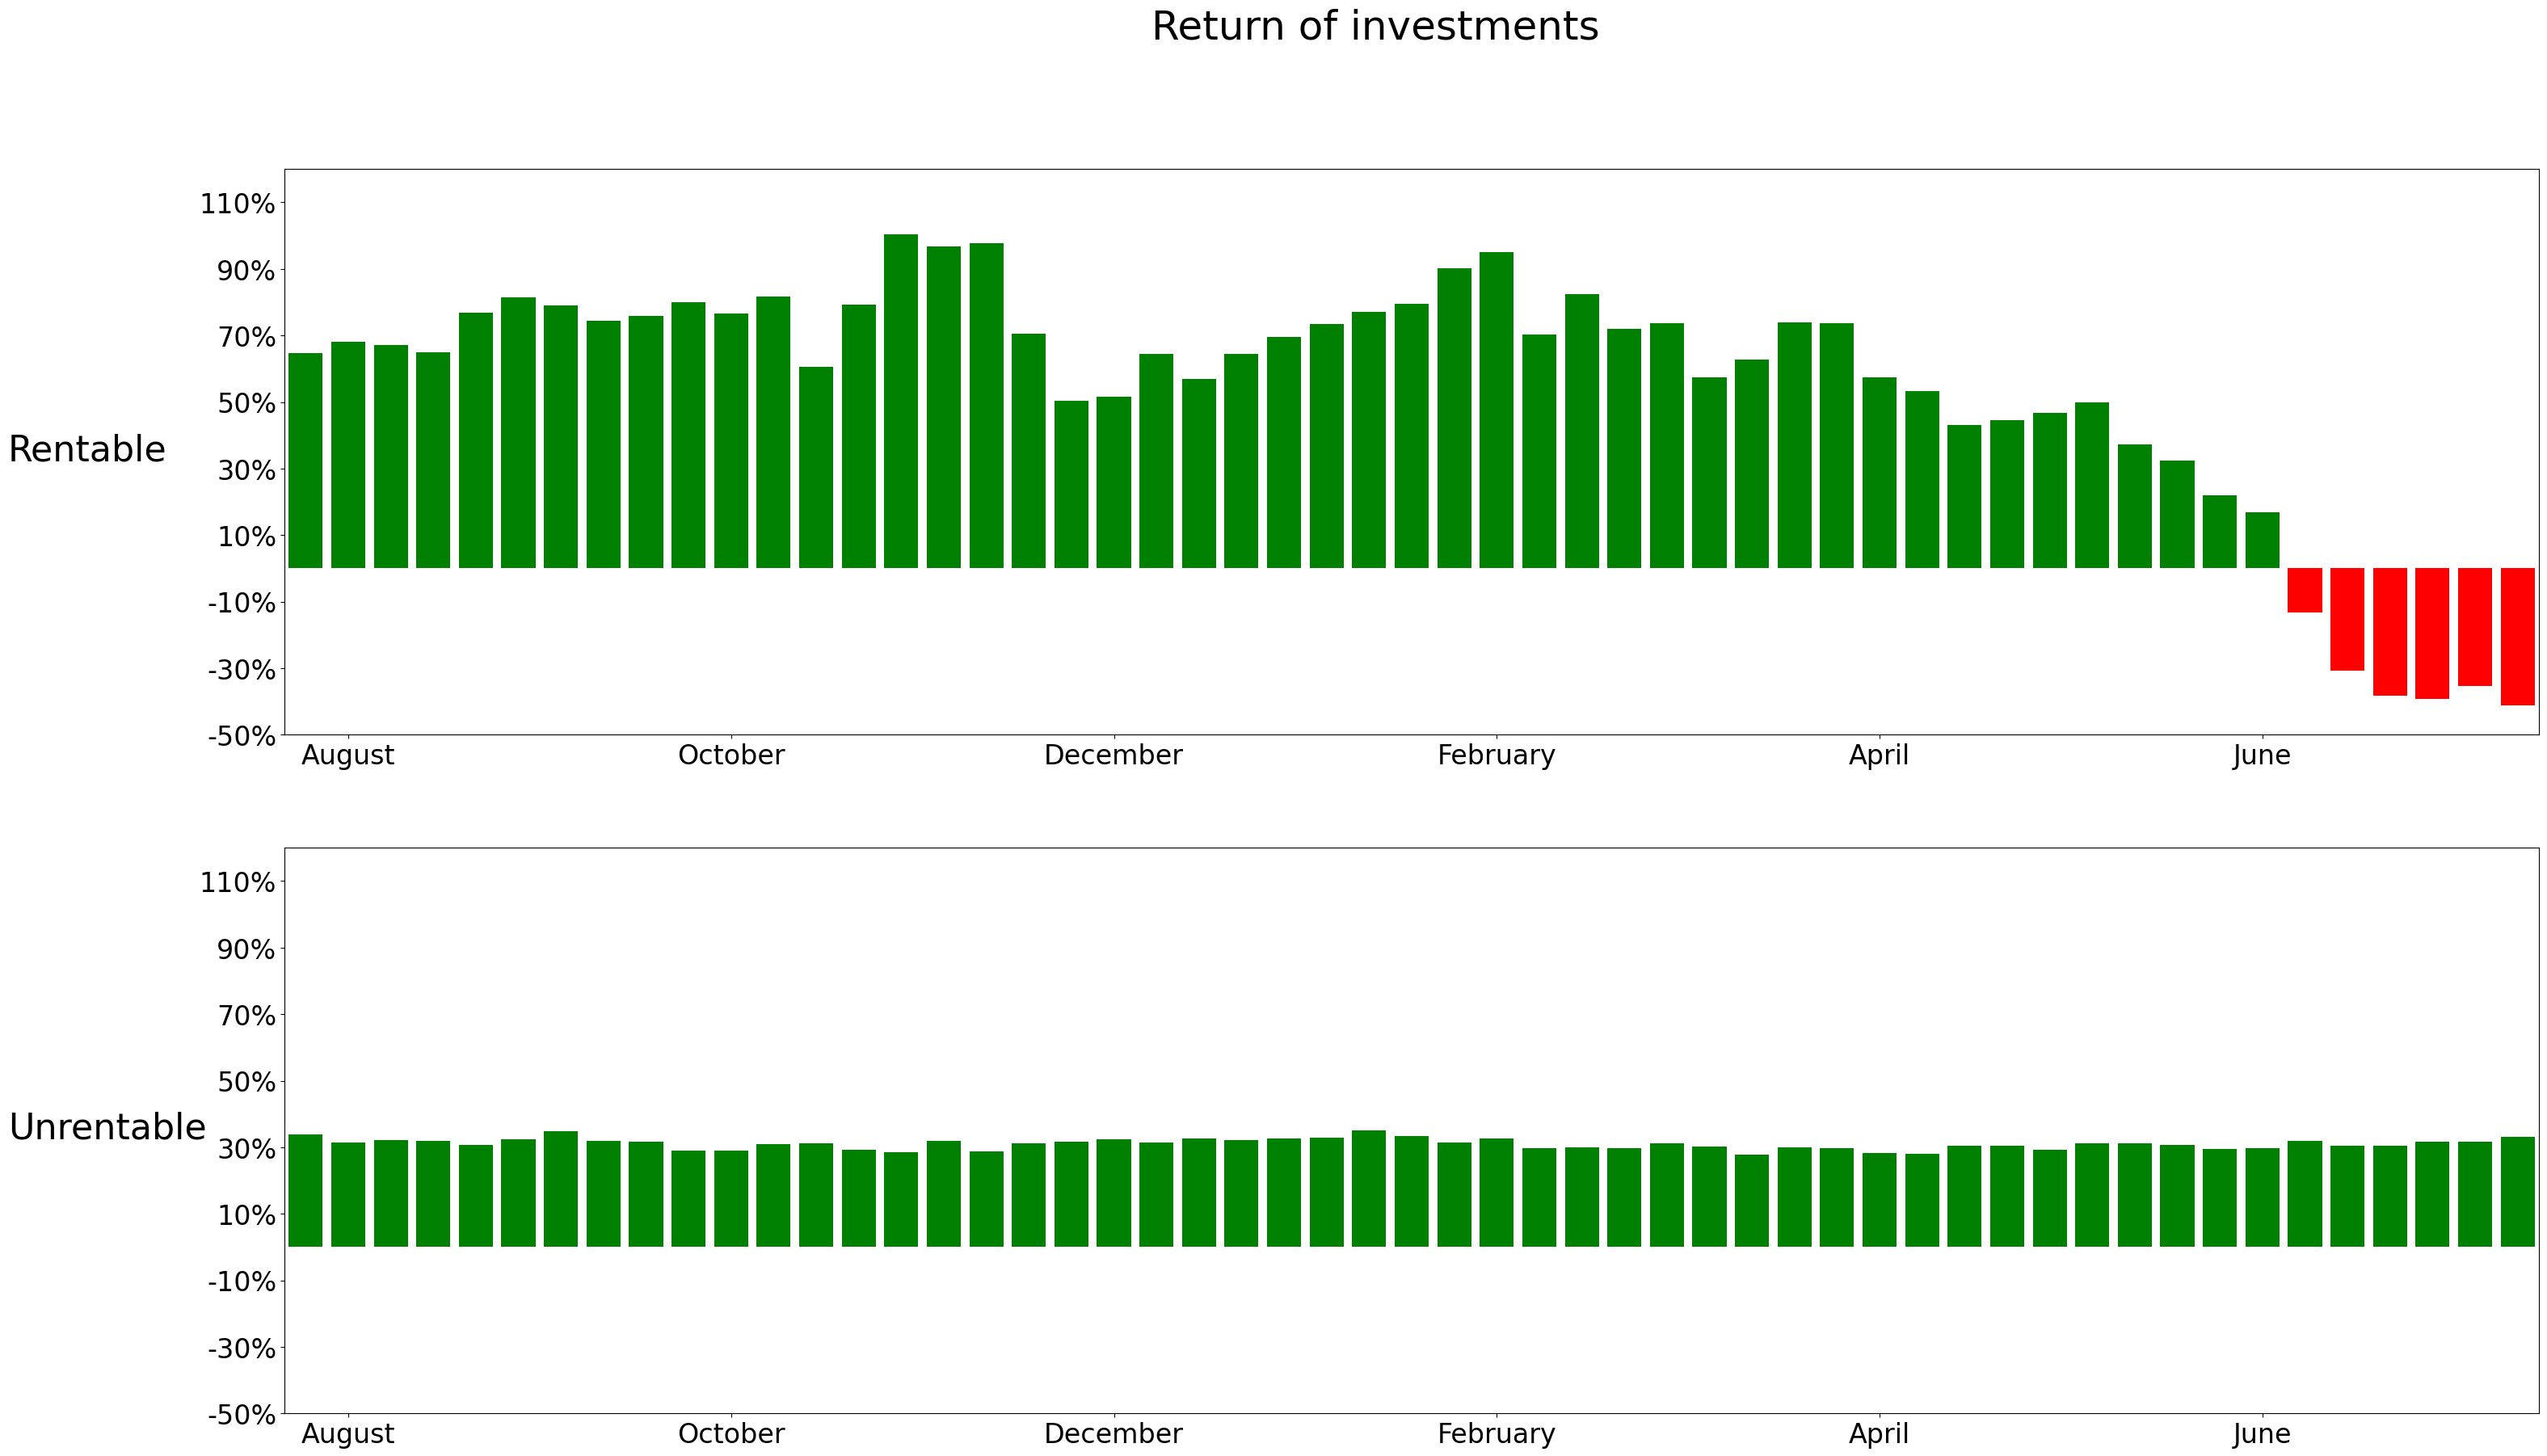

In [29]:
fig, axis = plt.subplots(2,1)
fig.set_size_inches(36,20)
fig.suptitle("Return of investments", fontsize = 36)
draw_bar(axis[0], ROI[ROI["is_rental"]==1]["ROI"])
fig.text(s="Rentable",x=0.03, y = 0.70, fontsize = 32)
fig.text(s="Unrentable",x=0.03, y = 0.28, fontsize = 32)
draw_bar(axis[1], ROI[ROI["is_rental"]!=1]["ROI"])
for ax in axis:
    ax.set_yticks(range(-50,121,20),[str(t)+'%' for t in range(-50,121,20)])
    ax.set_ylim([-50,120])

- Видно, что в начале товары, сдаваемые в аренду, имели высокий процент окупаемости, но, начиная с июня, являются причиной больших расходов.
- При этом товары на продажу являются источником стабильной прибыли

## ROI в разрезе аренды и статуса
- Рассмотрим ROI более подробно

In [30]:
data = dataset.groupby(["week","is_rental","status"])[["total_profit","total_cost"]].sum()
ROI = (data["total_profit"]/data["total_cost"]*100).reset_index(["is_rental","status"]).rename(
    columns={0:"ROI"})
ROI

,is_rental,status,ROI
week,,,
0,0,Returned,-5.878576
0,0,Shipped,34.618501
0,1,Returned,49.013977
0,1,Shipped,166.628902
1,0,Returned,-2.352115
...,...,...,...
51,1,Shipped,-35.866425
52,0,Returned,-12.726267
52,0,Shipped,33.477692


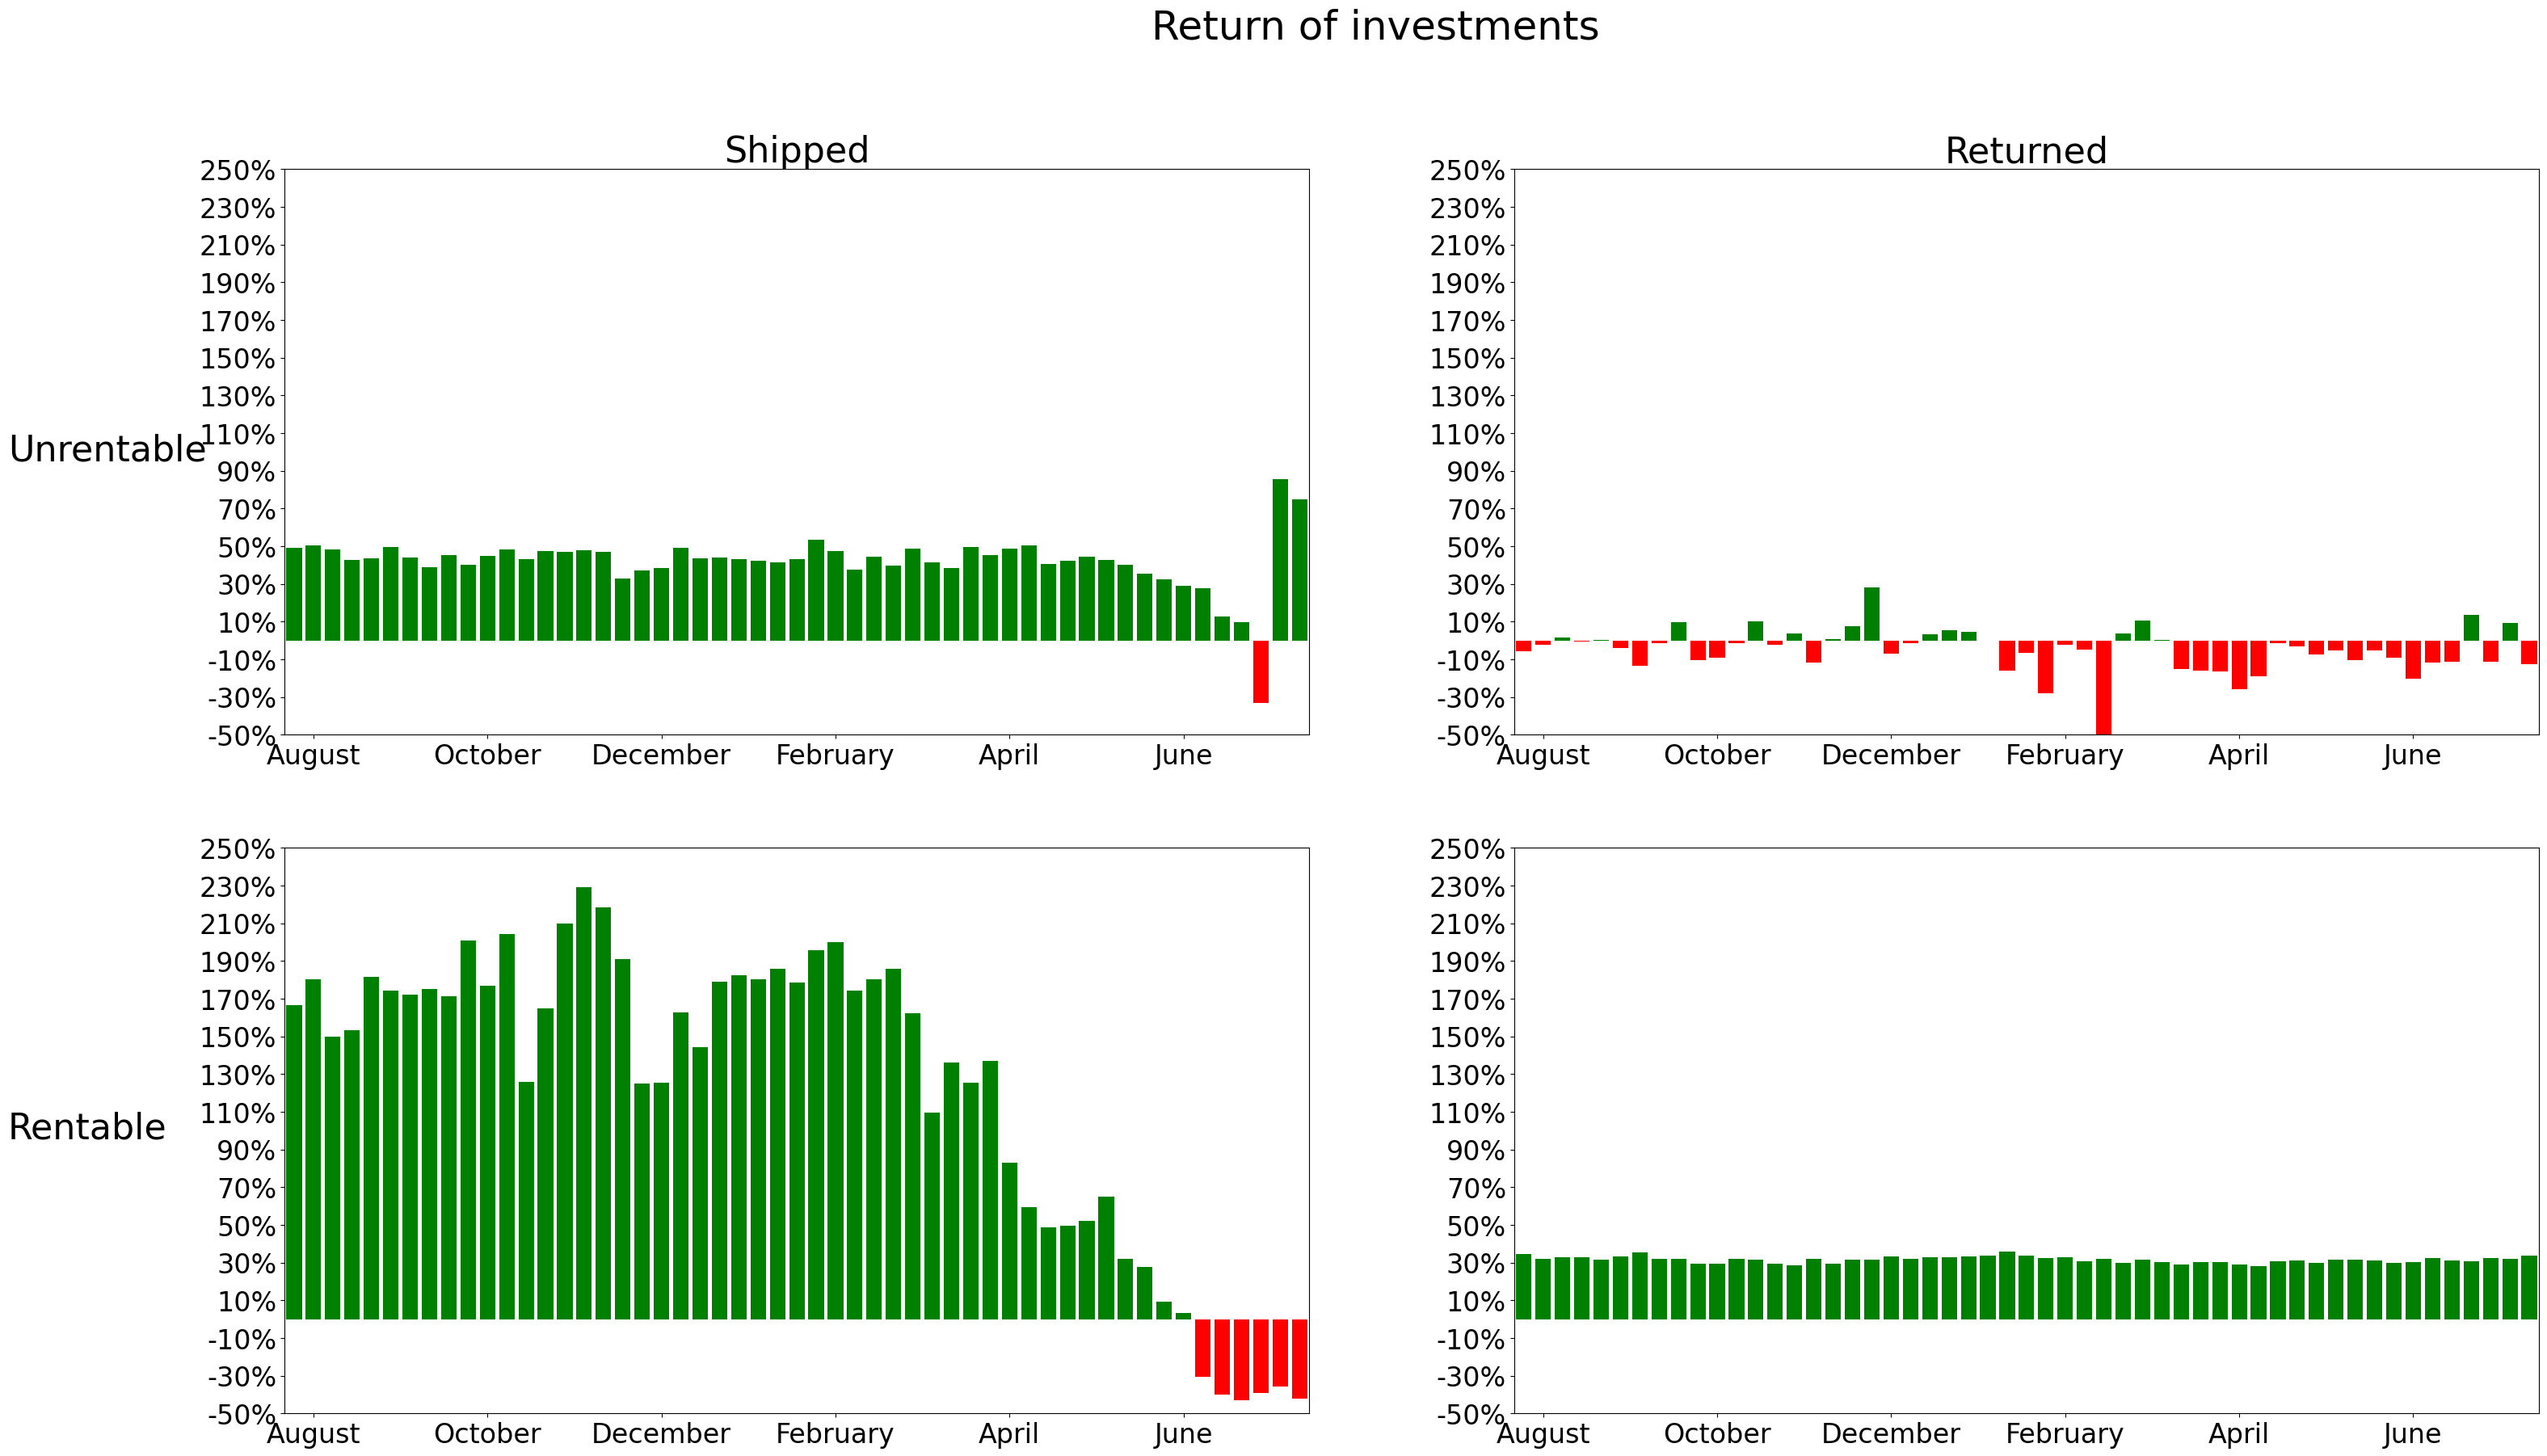

In [31]:
fig, axis = plt.subplots(2,2)
fig.set_size_inches(36,20)
fig.suptitle("Return of investments", fontsize = 36)
draw_bar(axis[0,0], ROI[(ROI["status"]=="Returned") & (ROI["is_rental"]==1)]["ROI"])
axis[0,1].set_title("Returned", fontsize=32)
axis[0,0].set_title("Shipped", fontsize=32)
fig.text(s="Unrentable",x=0.03, y = 0.70, fontsize = 32)
fig.text(s="Rentable",x=0.03, y = 0.28, fontsize = 32)
draw_bar(axis[1,0], ROI[(ROI["status"]!="Returned") & (ROI["is_rental"]==1)]["ROI"])
draw_bar(axis[0,1], ROI[(ROI["status"]=="Returned") & (ROI["is_rental"]==0)]["ROI"])
draw_bar(axis[1,1], ROI[(ROI["status"]!="Returned") & (ROI["is_rental"]==0)]["ROI"])

- Хорошо видно, что тренд на товары в аренду заканчивается, и успешно арендованные товары перестают приносить прибыль
- При этом интересно, что возвращенные купленные товары являются источником постоянных расходов
- Видно, что 1 неделю в июле наблюдался резкий спад с последующим ростом доходности товаров на продажу, что может быть связанно, например, со скидками на такие товары. 

# Выводы

- По итогам исследования видно, что последние 2 месяца прибыль падает. Это связанно с тем, что товары, сдаваемые в аренду, которые составляют около 40% от всех товаров, приносили огромную прибыль более полугода, но с мая перестали быть таковыми, и теперь являются источником расходов. Также источником расходов являются проданные товары, которые вернули, однако возвращенных товаров в последние 2 месяца было около 10%, поэтому их можно считать причиной убытков только косвенно.
- Рекомендации по повышению доходности:
    1. Сосредоточить все внимание на продуктах сдаваемых в аренду, либо сокращать расходы на них с сохранением выручки, либо всячески уменьшать их количество по отношению к товарам на продажу.
    2. Уменьшать убыток несенный с возвратом товаров на продажу. Например, путем оптимизации логистики, либо с увеличением/вводом комиссии на возрват товаров

# Расчет будущих продаж с помощью линейной регрессии
- Прогнозируем прибыль с помошью регрессионного анализа, будем находить функцию наилучшего приближения с помощью МНК и экстраполировать ее на следующий квартал
- Для прогноза разобьем продажи по неделям и для построения регрессии будем использовать 40 первых точек, а остальные 12 для проверки полученной модели

In [32]:
norders = dataset.groupby("week")["total_profit"].count().reset_index()
x = norders["week"][:40]
y = norders["total_profit"][:40]
x0 = np.linspace(0,53,500)
norders.head(10)

,week,total_profit
0,0,2516
1,1,3007
2,2,4955
3,3,4422
4,4,3075
5,5,2425
6,6,1662
7,7,1360
8,8,1362
9,9,1208


In [33]:
def LBF(x, coeffs):
    return sum([coeff*(x**i) for i, coeff in enumerate(coeffs)])

In [34]:
font = {"size" : 10}
matplotlib.rc('font', **font)
def plotting(axis, coeffs):
    axis.scatter(x,y, s = 20)
    axis.plot(x0, LBF(x0, coeffs), color = "green")
    axis.set_title(f"{len(coeffs) - 1} degree polynomial")
    axis.scatter(norders["week"][40:],norders["total_profit"][40:],
                     s = 20, c = "none", linewidth = 1, edgecolors = "royalblue")

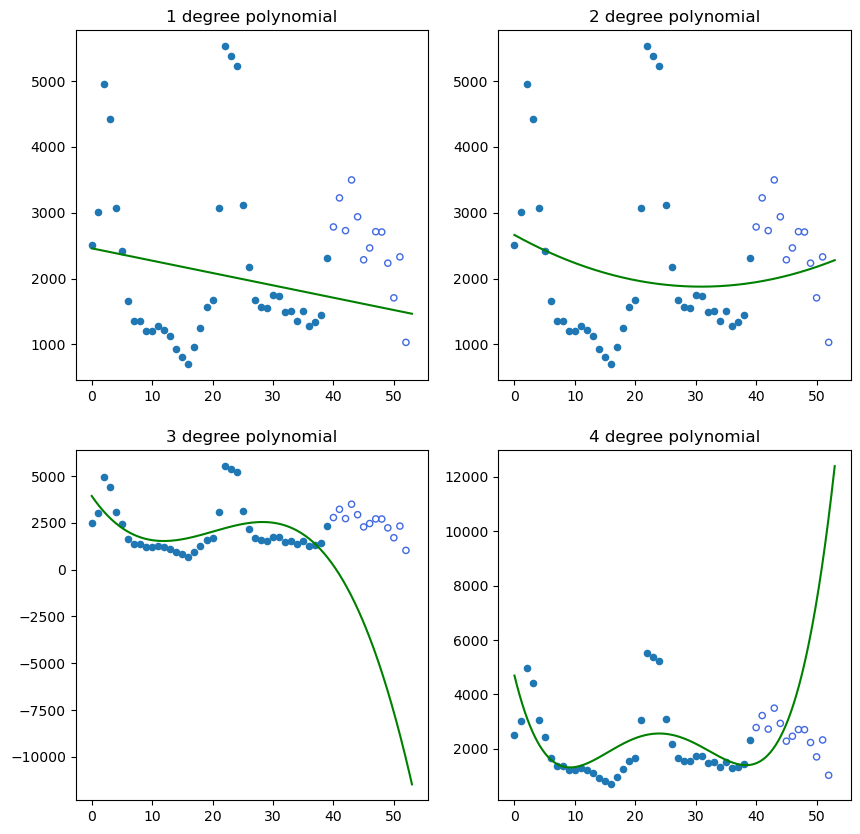

In [35]:
fig, axis = plt.subplots(2,2)
fig.set_size_inches(10, 10)
plotting(axis[0,0], np.polyfit(x,y,deg=1)[::-1])
plotting(axis[0,1], np.polyfit(x,y,deg=2)[::-1])
plotting(axis[1,0], np.polyfit(x,y,deg=3)[::-1])
plotting(axis[1,1], np.polyfit(x,y,deg=4)[::-1])
#plotting(axis[1,1], np.polyfit(x,y,deg=10)[::-1])

- Видно, что наилучшим приближением оказался полином 2 степени
- Регрессионный анализ является не лучшим методом для текущих данных 

### Полученная прибыль по неделям

In [36]:
xf = np.arange(53,66)
estimated_profit = pd.Series(data = LBF(xf, np.polyfit(x,y,deg=2)[::-1]), index = xf)
estimated_profit

53    2278.169087
54    2315.347912
55    2354.171611
56    2394.640184
57    2436.753632
58    2480.511954
59    2525.915150
60    2572.963221
61    2621.656167
62    2671.993986
63    2723.976680
64    2777.604249
65    2832.876692
dtype: float64

### Визуализация в виде графика

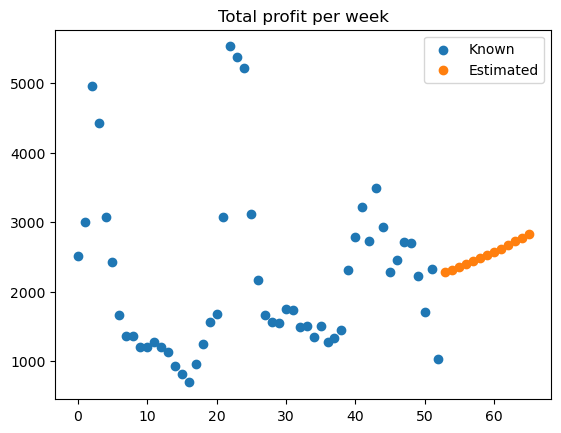

In [37]:
plt.scatter(norders["week"],norders["total_profit"], label="Known")
plt.scatter(x=estimated_profit.index, y=estimated_profit.values, label="Estimated")
plt.title("Total profit per week")
plt.legend()
plt.show()